In [1]:
# 1. Import necessary libraries
import os
import requests
from PIL import Image

import torch
dev = None
if torch.cuda.is_available():
  dev = torch.device('cuda')
else:
  dev = torch.device("cpu")
print(f"Using device '{dev}'")

from torchvision import models, transforms
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import copy
import json

Using device 'cpu'


In [2]:
# 2. USER INPUT: IMAGE AND DESIRED TARGET CLASS

# Get the current working directory
current_path = os.getcwd()

# Get image filename
image_path = current_path + "/labradorRetriever.jpeg"  

# Specify target class for adversarial attack
target_string = 'banana'

# Check if the target class was part of the training labels of ResNet50
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = requests.get(imagenet_classes_url).json()
if target_string in imagenet_classes: 
    print('target exists in training set')
else: 
    print('target not included in training set, choose another target')

target exists in training set


In [3]:
# 3. Set parameters
epsilon = 0.1 # noise added to the adversarial image


In [4]:
# 4. Create basic function for plotting

def plot_image_with_label(image, output): 
    
    # function to plot the input image of the model and the label assigned
    # image = input image, expected to be in PIL image format
    # output = output from the model, containing the probabilities for all the classes
     
    # Convert ResNet50 output to probabilities
    probabilities = F.softmax(output, dim=1)
    
    # Get index of most likely class
    index = torch.argmax(probabilities, dim=1).item()

    # Get the probability of the most likely class
    p = probabilities[0, index].item()
    
    # Create figure
    plt.imshow(image) # plot image
    plt.title(f"Predicted class: {imagenet_classes[index]} with p = {p:.3}") # indicate predicted label and p
    plt.axis('off') # remove axis
    plt.show() # show figure

In [5]:
# 5. Upload input image and apply transformations

# Load image
image = Image.open(image_path).convert("RGB") 

# Function to convert image to the size used to train ResNet50 (224 x 224 pixels)
input_transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224)])

# Function used later to transform image to tensor and from tensor to image
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# Resize input image and convert to tensor
image = input_transform(image)
img_tensor = to_tensor(image)

In [6]:
# 6. Load pre-trained model 
resnet50 = models.resnet50(pretrained=True).to(dev)
resnet50.eval()

# Add a normalization layer to the model before the pre-existing input layer
normalization_layer = transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]
                        )

# Make a copy of the model just in case
model = copy.deepcopy(resnet50)

# Prepend the transformation
model = nn.Sequential (normalization_layer, model)

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


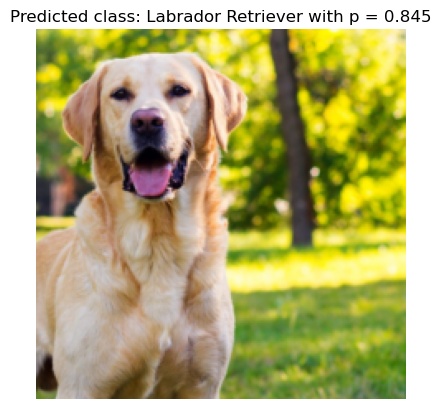

In [7]:
# 7. Predict label of original image + plot

# Input tensor image to the model and make prediction
output = model(img_tensor.unsqueeze(0)) # we need to add a fourth dimension to the tensor

# Plot results
plot_image_with_label(image, output)

In [8]:
# 8. Perform adversarial attack using FGSM and obtain modified image

# Find index of target label
target_id = imagenet_classes.index(target_string) # get index of target class
target_tensor = torch.tensor(target_id).unsqueeze(0) # convert index into tensor

# Set up autograd
img_tensor.requires_grad = True
model.zero_grad()

# Compute the loss gradient
output = model(img_tensor.unsqueeze(0))
loss = F.cross_entropy(output, target_tensor)
loss.backward()

# Create new image tensor adding noise in the direction of the gradient
adv_tensor = img_tensor + epsilon * img_tensor.grad.sign()

# Make sure the values of the new tensor are within the accepted range of values for ResNet50 ([0,1])
adv_tensor = torch.clamp(adv_tensor, 0, 1).detach()


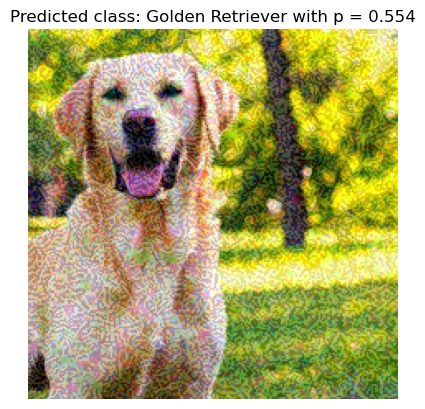

In [9]:
# 9. Predict label of modified image + plot
output = model(adv_tensor.unsqueeze(0)) # we need to add a fourth dimension to the tensor

# convert adversarial tensor to image for plotting
adv_image = to_pil(adv_tensor)
plot_image_with_label(adv_image, output)

In [10]:
# 10. Save modified image

# adversarial image filepath
adv_path = current_path + '/adversarial_image.jpg'

# Save the image
adv_image.save(adv_path)